# To-Do next:
1. ~~Make `scene_path` update using `get_scene_path`~~
2. ~~Update `scene` in `sim_settings` to use the new `scene_path`~~
3. ~~Fix the positioning of agent on the map (done?)~~
4. ~~Create a video showing the agent spinning around to demonstrate environment~~
5. Check to see if there is a better way to account for agent height (?)
6. ~~Work out 360 view~~ _(Assuming that this is not required for now)_
7. ~~Work out prompt for agent to describe task~~
8. ~~Hook up a ViT~~
9. Functionise everything
10. Make agent take a series of steps
11. Plot trajectory on a map

# Major milestones
1. ~~Map agent in environment~~
2. Agent random-walk with position trace
3. Work out 360 view
4. ~~Hook up vision transformer~~
5. Hook up LLM
6. Hook up second vision transformer
7. ??
8. Write-up

# Basic Schematic

![Basic Schematic of Modelling Approach](basic_schematic.drawio.png)

# Preamble
Setting up:
 - Required modules
 - Folder paths
 - Useful functions
 - Creating simulator instance and reading in the data

In [1]:
# Required imports
import os
import json
import numpy as np
import pandas as pd
import random
import imageio
import magnum as mn
from PIL import Image
from matplotlib import pyplot as plt
import math
import cv2

import habitat_sim
from habitat_sim.utils import common as utils
from habitat_sim.utils import viz_utils as vut
from habitat.utils.visualizations import maps
import magnum as mn

import torch
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring


In [2]:
# setting up folder paths
habitat_dir_path = "/home/wes/habitat/data/"
rxr_data_path = "/media/wes/Lexar/rxr_data/rxr-data/"
output_dir_path = "/home/wes/Documents/git_ws/OCOM5300M_ResearchProject/outputs/"

scene_dir_path = os.path.join(habitat_dir_path, f"scene_datasets/mp3d/")
pose_dir_path = os.path.join(rxr_data_path, f'pose_traces/rxr_train/')
mp3d_scene_config = os.path.join(scene_dir_path, f"mp3d.scene_dataset_config.json")

scene_path = ''

annotations_fname = "rxr_train_guide.jsonl/rxr_train_guide.json"
annotations_path = os.path.join(rxr_data_path, annotations_fname)

In [3]:
# checking that paths exist
print(f'Exists: {os.path.exists(scene_dir_path)} \t scene_dir_path: {scene_dir_path}')
print(f'Exists: {os.path.exists(pose_dir_path)} \t pose_dir_path: {pose_dir_path}')
print(f"Exists: {os.path.exists(mp3d_scene_config)} \t mp3d_scene_config: {mp3d_scene_config}")

Exists: True 	 scene_dir_path: /home/wes/habitat/data/scene_datasets/mp3d/
Exists: True 	 pose_dir_path: /media/wes/Lexar/rxr_data/rxr-data/pose_traces/rxr_train/
Exists: True 	 mp3d_scene_config: /home/wes/habitat/data/scene_datasets/mp3d/mp3d.scene_dataset_config.json


## Preamble: Utility Functions
### Path updates

In [4]:
# Returns the full filepath of a scene given a scene id (i.e. scan id)
def get_scene_path(scene_id):
    global scene_dir_path
    return os.path.join(scene_dir_path, f"{scene_id}/{scene_id}.glb")

In [5]:
# Propagate the new scene filepath across all relevant dictionaries, etc.
def update_scene_path(scene_id):
    global scene_dir_path
    global sim_settings
    
    scene_path = get_scene_path(scene_id)
    sim_settings['scene'] = scene_path

    return

### Display Observations

In [6]:
# Change to do something like this maybe: https://stackoverflow.com/a/41432704
#    i.e. show multiple subplots on one plot
def display_sample(rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])):
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGBA")

    arr = [rgb_img]
    titles = ["rgb", "depth"]
    if semantic_obs.size != 0:
        semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray((depth_obs / 10 * 255).astype(np.uint8), mode="L")
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 2, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)


if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--no-display", dest="display", action="store_false")
    parser.add_argument("--no-make-video", dest="make_video", action="store_false")
    parser.set_defaults(show_video=True, make_video=True)
    args, _ = parser.parse_known_args()
    show_video = args.display
    display = args.display
    do_make_video = args.make_video
else:
    show_video = False
    do_make_video = False
    display = False

# import the maps module alone for topdown mapping
if display:
    from habitat.utils.visualizations import maps

### Configuring Simulator Settings

In [7]:
# Default sim settings
rgb_sensor = True
depth_sensor = True
semantic_sensor = False
seed = 1
number_images_for_panorama = 4 # number of images required for a full 360 degree panorama to be created


sim_settings = {
    "width": 256,  # Spatial resolution of the observations
    "height": 256,
    "scene": scene_path,  # Scene path
    "scene_dataset": mp3d_scene_config,  # the scene dataset configuration files
    "default_agent": 0,
    "sensor_height": 1.0,  # Height of sensors in meters
    "color_sensor": rgb_sensor,  # RGB sensor
    "depth_sensor": depth_sensor,  # Depth sensor
    "semantic_sensor": semantic_sensor,  # Semantic sensor
    "seed": seed,  # used in the random navigation
    "enable_physics": False,  # kinematics only    
    "hfov" : 360 / number_images_for_panorama
}

In [8]:
# Sim config factory?
def make_cfg(settings):
    sim_cfg = habitat_sim.SimulatorConfiguration()
    sim_cfg.gpu_device_id = 0
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["scene_dataset"]
    sim_cfg.enable_physics = settings["enable_physics"]

    sensor_specs = []

    # RGB sensor specs
    color_sensor_spec = habitat_sim.CameraSensorSpec()
    color_sensor_spec.uuid = "color_sensor"
    color_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
    color_sensor_spec.resolution = [settings["height"], settings["width"]]
    color_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    color_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    color_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(color_sensor_spec)

    # Depth sensor specs
    depth_sensor_spec = habitat_sim.CameraSensorSpec()
    depth_sensor_spec.uuid = "depth_sensor"
    depth_sensor_spec.sensor_type = habitat_sim.SensorType.DEPTH
    depth_sensor_spec.resolution = [settings["height"], settings["width"]]
    depth_sensor_spec.position = [0.0, settings["sensor_height"], 0.0]
    depth_sensor_spec.sensor_subtype = habitat_sim.SensorSubType.PINHOLE
    depth_sensor_spec.hfov = settings["hfov"]
    sensor_specs.append(depth_sensor_spec)

    #agent movement
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "move_forward" : habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=1.0)
        ),
        "turn_left":habitat_sim.agent.ActionSpec(
            "turn_left", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "turn_right":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=90.0)
        ),
        "turn_around":habitat_sim.agent.ActionSpec(
            "turn_right", habitat_sim.agent.ActuationSpec(amount=180.0)
        )
    }
    return habitat_sim.Configuration(sim_cfg, [agent_cfg])


### Mapping agent position to a topdown map of the environment

In [9]:
# convert 3d points to 2d topdown coordinates
def convert_points_to_topdown(pathfinder, points, meters_per_pixel):
    points_topdown = []
    bounds = pathfinder.get_bounds()
    for point in points:
        # convert 3D x,z to topdown x,y
        px = (point[0] - bounds[0][0]) / meters_per_pixel
        py = (point[2] - bounds[0][2]) / meters_per_pixel
        points_topdown.append(np.array([px, py]))
    return points_topdown


# display a topdown map with matplotlib
def display_map(topdown_map, key_points=None):
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(1, 1, 1)
    ax.axis("off")
    #ax.set_xlim([-30, 30])
    #ax.set_ylim([-30,30])
    plt.imshow(topdown_map)
    # plot points on map
    if key_points is not None:
        for point in key_points:
            plt.plot(point[0], point[1], marker="o", markersize=10, alpha=0.8)
            print(f'Adding point to {point[0]}, {point[1]}')
    plt.show(block=False)

In [10]:
def draw_map(agent, scene_id, meters_per_pixel = 0.025, height = 1, agent_radius_px = 8):
    print(f"Showing map for scene: {scene_id}")
    print(f"The NavMesh bounds are: {str(sim.pathfinder.get_bounds())}")
    
    agent_pos = agent.get_state().position
    agent_forward = utils.quat_to_magnum(agent.get_state().rotation).transform_vector(mn.Vector3(0,0,-1.0))
    agent_orientation = math.atan2(agent_forward[0], agent_forward[2])

    topdown_map = maps.get_topdown_map(
        sim.pathfinder, height=agent_pos[1], meters_per_pixel = meters_per_pixel
    )
    recolor_map = np.array(
        [[255,255,255],[128,128,128], [0,0,0]], dtype=np.uint8
    )
    topdown_map = recolor_map[topdown_map]

    grid_dimensions = (topdown_map.shape[0], topdown_map.shape[1])
    print(f'Grid Dimension: {grid_dimensions}')

    agent_grid_pos = maps.to_grid(agent_pos[2], agent_pos[0], grid_dimensions, pathfinder=sim.pathfinder)

    maps.draw_agent(topdown_map, agent_grid_pos, agent_orientation, agent_radius_px=agent_radius_px)

    return topdown_map

### Loading annotations file

In [11]:
# Utility function to read rxr data and return it as a dataframe
def json_to_df(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))

    return pd.DataFrame(data)    

### Translating `rxr` viewpoint IDs into `habitat-sim` positions

In [12]:
# Takes a scan id (aka: scene_id) and annotation file path
# Returns a list of scene_ids and associated instruction_ids and instructions
# If scan_id is provided, then only annotations and instruction ids for the scene_id is returned
def get_rxr_annotations(annotations_path, scan_id_list = 'None'):
    if not os.path.exists(annotations_path):
        print(f'Annotation path not found: {annotations_path}')
        return

    n_records = 0
    rxr_annotations = {}
    # Turning entire annotation json into dataframe
    df_rxr = json_to_df(annotations_path)
    
    # Focusing on just the english instructions for now
    df_rxr = df_rxr[df_rxr['language']=='en-US']

    # If no scan_id provided, go through entire dataset
    if scan_id_list == 'None':
        scan_id_list = df_rxr['scan'].unique().tolist()

    # Return a dictionary
    # key = scan_id
    # value = [{instruction_id}:{instructions}, ...]
    for scan_id in scan_id_list:
        rxr_annotations[scan_id] = df_rxr[df_rxr['scan']==scan_id][['instruction_id', 'instruction']].to_dict('records')
        n_records += len(rxr_annotations[scan_id])

    return scan_id_list, rxr_annotations, n_records

In [13]:
# Takes an instruction_id and returns the pose trace
def get_pose_trace(pose_dir_path, instruction_id):
    instruction_id = ('000000' + str(instruction_id))[-6:] # Appending zeros to match file name nomenclature
    pose_trace_path = os.path.join(pose_dir_path, f'{instruction_id}_guide_pose_trace.npz')
    if not os.path.exists(pose_trace_path):
        print(f'pose_trace_path not found: {pose_trace_path}')
        return

    pose_trace = np.load(pose_trace_path)['extrinsic_matrix']
    return pose_trace

In [14]:
# Takes a pose trace dataset and returns a list of all unique positions
#  and a list of the rotation based on that unique position
def get_unique_positions(pose_trace):
    unique_position_list = np.zeros((1,3))
    unique_rotation_list = np.zeros((1,3,3))
    for pose in pose_trace:
        if not np.all(np.isin(pose[:3,3], unique_position_list)):
            unique_position_list = np.append(unique_position_list, np.array(pose[:3,3]).reshape(1,3), axis=0)
            unique_rotation_list = np.append(unique_rotation_list, np.array(pose[:3,:3]).reshape(1,3,3), axis=0)

    return np.squeeze(unique_position_list[1:]), unique_rotation_list[1:]

### Creating a 360 view of current agent position

In [15]:
# function to get current 360 view
def get_current_observations(agent):
    rotation_size = sim_settings["hfov"]
    number_of_captures = int(360 / rotation_size)
    initial_orientation = agent.get_state().rotation
    
    color_observations = []

    for i in range(number_of_captures + 1):  # +1 to return agent back to original orientation
        agent_state = agent.get_state()
        rotation_amount = habitat_sim.utils.quat_from_angle_axis(
            np.deg2rad(-rotation_size * i), np.array([0,1,0]) # Clockwise rotation about the Y-axis
        )
        agent_state.rotation = initial_orientation * rotation_amount
        
        agent.set_state(agent_state)
        observations = sim.get_sensor_observations()
        color_observations.append(observations["color_sensor"])
    
    agent_views = {
        "forward" : color_observations[0],
        "right" : color_observations[1],
        "behind" : color_observations[2],
        "left" : color_observations[3]
    }
    
    return agent_views, color_observations[:-1]

# Testing on a single scan

## Testing on a single instruction set

In [16]:
scan_id_list, rxr_annotations, n_records = get_rxr_annotations(annotations_path)

In [17]:
print(f'List of scan ids (top 5): {scan_id_list[:5]}')
print(f'List of annotations (top 2): {rxr_annotations[scan_id_list[0]][:2]}')
print(f'Total number of annotations: {n_records}')

List of scan ids (top 5): ['SN83YJsR3w2', '7y3sRwLe3Va', 'S9hNv5qa7GM', 'ur6pFq6Qu1A', 'mJXqzFtmKg4']
List of annotations (top 2): [{'instruction_id': 0, 'instruction': "You will start by standing in front of a glass door and on your right is a doorway. Turn around and you will see a doorway to the washroom. Walk towards the doorway and inside the washroom. Once you're there, stand in between the sink and the bathtub and once you're there, you're done."}, {'instruction_id': 651, 'instruction': "You're facing a fireplace turn around and hop over this table with the white chairs towards the doorway in front of you. And take a step to the left of this circular white table. And walk to the left of the stairs past this rug. And walk through this doorway in front of you and then walk through the next one you'll come to a room with a rug and a table in the middle. Take a step towards the yellow couch on the left. And hop over this couch towards the armchair at the left and once you're in fron

In [18]:
instruction_id = rxr_annotations[scan_id_list[2]][0]['instruction_id']
nav_instructions = rxr_annotations[scan_id_list[2]][0]['instruction']
pose_trace = get_pose_trace(pose_dir_path, instruction_id)

In [19]:
unique_position_list, unique_rotation_list = get_unique_positions(pose_trace)

print(f'Number of unique positions: {len(unique_position_list)}')
print(f'Example of starting position: {unique_position_list[0]}')
print(f'Example of starting rotation: \n {unique_rotation_list[0]}')
print()
print(f'Navigation instructions: {nav_instructions}')

Number of unique positions: 811
Example of starting position: [-13.39589977   1.56108999  -6.45393991]
Example of starting rotation: 
 [[ 0.16610284  0.          0.98610842]
 [ 0.          1.          0.        ]
 [-0.98610842  0.          0.16610284]]

Navigation instructions: You begin facing a wall, turn to your left, take a step towards the front of the bed, using the door that's to the left of the dresser, exit the bedroom, you will enter a hallway, once you've entered the hallway, look immediate to your left, there will be an opening, take a step towards the opening, once you're standing in the hallway, outside of the opening facing the living room with the red couches, you are done.


In [20]:
scene_id = scan_id_list[2]
update_scene_path(scene_id)

## Creating simulator instance

In [21]:
# Create configuration
cfg = make_cfg(sim_settings)

In [22]:
# Create simulator instance
sim = habitat_sim.Simulator(cfg)

Renderer: NVIDIA GeForce RTX 4090/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.107.02
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


PluginManager::Manager: duplicate static plugin StbImageImporter, ignoring
PluginManager::Manager: duplicate static plugin GltfImporter, ignoring
PluginManager::Manager: duplicate static plugin BasisImporter, ignoring
PluginManager::Manager: duplicate static plugin AssimpImporter, ignoring
PluginManager::Manager: duplicate static plugin AnySceneImporter, ignoring
PluginManager::Manager: duplicate static plugin AnyImageImporter, ignoring
[09:17:10:437559]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'mp3d' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.


## Snapping agent to first position described in pose

In [23]:
agent = sim.get_agent(0)
agent_state = habitat_sim.AgentState()

In [24]:
unique_position_idx = 0

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# -------- Turn this into a function -------------
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

agent_pos = unique_position_list[unique_position_idx]
agent_rotation = unique_rotation_list[unique_position_idx]

print(f'Snapping agent to: {agent_pos}')

agent_rotation_q = mn.Quaternion.from_matrix(mn.Matrix3(agent_rotation))
agent_rotation = utils.quat_from_magnum(agent_rotation_q)

agent_state.position = agent_pos - np.array([0, sim_settings['sensor_height'], 0])
agent_state.rotation = agent_rotation
agent.set_state(agent_state)
print(f'Agent oriented to: {agent_rotation}')

Snapping agent to: [-13.39589977   1.56108999  -6.45393991]
Agent oriented to: quaternion(0.763578057289124, 0, 0.645715534687042, 0)


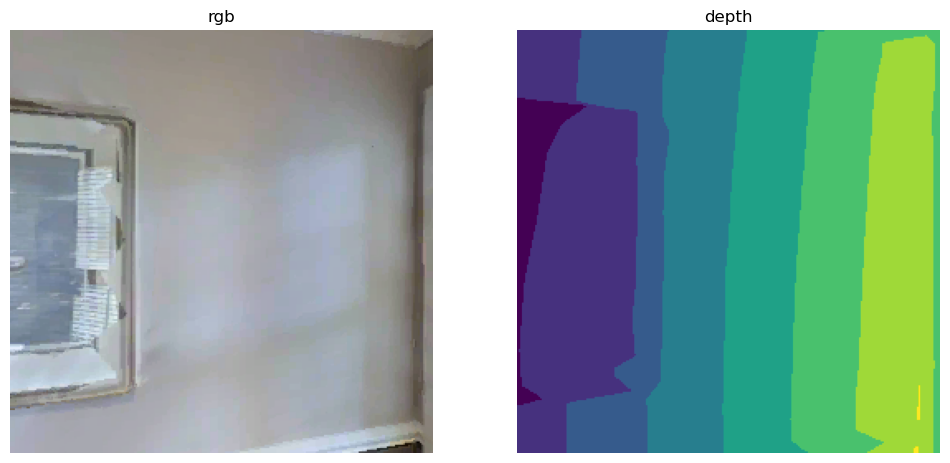

In [25]:
observations = sim.get_sensor_observations()
rgb = observations['color_sensor']
depth = observations['depth_sensor']
display_sample(rgb, np.array([]), depth)

## Scene Position Mapping

Showing map for scene: S9hNv5qa7GM
The NavMesh bounds are: (array([-15.875654,  -0.083722,  -7.894658], dtype=float32), array([3.448215, 7.532459, 8.175301], dtype=float32))
Grid Dimension: (642, 772)


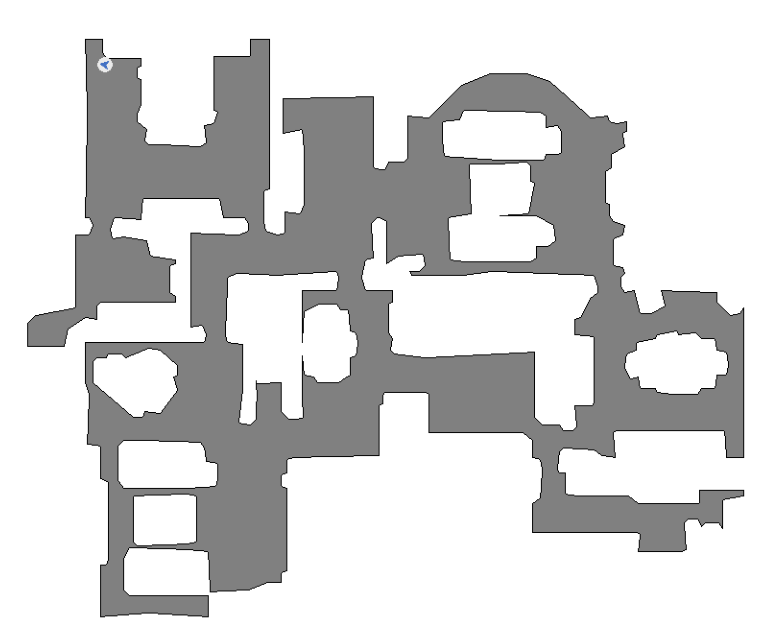

In [26]:
topdown_map = draw_map(agent, scene_id)
display_map(topdown_map)

## Creating panoramic view of current position

In [27]:
print(agent_state.position)
print(agent_state.rotation)

[-13.39589977   0.56108999  -6.45393991]
quaternion(0.763578057289124, 0, 0.645715534687042, 0)


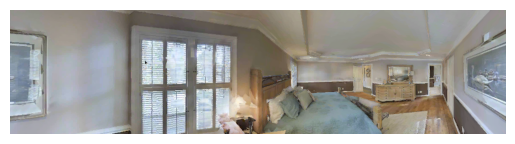

In [28]:
agent_views, color_observations = get_current_observations(agent)
plt.imshow(cv2.hconcat(color_observations))
plt.axis("off")
plt.show()

# Testing out VLM
## Creating model instance

In [29]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto"
)

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [30]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

## Function to generate outputs from VLM

In [31]:
def generate_outputs_qwen2(model, processor, messages):
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
            text = [text],
            images = image_inputs,
            videos = video_inputs,
            padding = True,
            return_tensors = "pt",
        )
    
    inputs = inputs.to("cuda")
    
    generated_ids = model.generate(**inputs, max_new_tokens=128)
    generated_ids_trimmed = [out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)]
    output_text = processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)

    return output_text

## Function to create VLM prompts

In [32]:
def prompt_launch_instructions(model, processor, nav_instructions):
    messages = [
        {"role" : "system",
         "content" : 
             '''You are an embodied agent tasked with following a set of instructions provided to you in order to navigate around an environment.
             Take the navigation instructions provided to you and create a list of steps that you must follow in order to achieve your goal.'''
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": f"Navigation instructions: {nav_instructions}"},
            ],
        }
    ]

    return generate_outputs_qwen2(model, processor, messages)

In [33]:
def prompt_observe(model, processor, agent_views):
    view_description = {}
    views = ["forward", "right", "behind", "left"]
    image_prompts = {
        "forward" : "This is your view directly in front of you",
        "left" : "This is your view 90 degrees to the left of you",
        "right" : "This is your view 90 degrees to the right of you",
        "behind" : "This is your view directly behind you"
    }
    
    for view in views:
        messages = [
            {"role" : "system",
             "content" : "You are an embodied agent tasked with understanding your environment. You are provided images from your sensors and will describe what you see in less than 50 words."
            },
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": Image.fromarray(agent_views[view])},
                    {"type": "text", "text": image_prompts[view]},
                ],
            }
        ]
        view_description[view] = generate_outputs_qwen2(model, processor, messages)

    return view_description

In [34]:
def prompt_decide_action(model, processor, inferred_nav_instructions, view_description, past_actions=[]):
    
    if len(past_actions) == 0:
        prompt_past_actions = ""
    else:
        prompt_past_actions = f'''The actions you have taken so far are: {past_actions}.'''
    
    messages = [
        {"role" : "system",
         "content" : 
             f'''You are an embodied agent tasked with following a set of instructions provided to you in order to navigate around an environment.
             Your navigation instructions are: {inferred_nav_instructions}.
             {prompt_past_actions}
             Use the images from your sensors provided to you to select an action from the following list: Move Forward, Turn Left, Turn Right, Turn to face behind you, Goal Reached'''
        },
        {
            "role": "user",
            "content": [
                {"type": "text", "text": 
                f'''
                To your front you see: {view_description["forward"]},
                To your right you see: {view_description["right"]},
                Directly behind you see: {view_description["behind"]},
                To your left you see: {view_description["left"]}
                '''},
            ],
        }
    ]

    return generate_outputs_qwen2(model, processor, messages)

## Function to take an action

In [35]:
# For continuous movement: To be implemented
env_settings = {
    "sim_time" : 10,
    "continuous_nav" : True,
    "control_frequency" : 5,
    "frame_skip" : 12,
}

In [36]:
def take_action(agent, action, env_settings):
    '''
    control_sequence = []
    
    sim_time = env_settings["sim_time"]
    control_frequency = env_settings["control_frequency"]
    frame_skip = env_settings["frame_skip"]
    fps = control_frequency * frame_skip
    '''
    if action != 'Goal Reached':
        action_dict = {
            "Move Forward" : "move_forward",
            "Turn Left" : "turn_left",
            "Turn Right" : "turn_right",
            "Turn to face behind you" : "turn_around",
        }
    
        agent.act(action_dict[action])

In [37]:
# saving time by not taking new observations if simply rotating
# !!!!!!!! Not used yet !!!!!!!!!!!
# !!!!!! To be implemented !!!!!!!!
def estimate_new_observations(action, color_observations, view_description):
    default_order = ["forward", "right", "behind", "left"]
    
    new_agent_views = {}
    new_view_description = {}
    
    if action == "Turn Left":
        new_order = ["left", "forward", "right", "behind"]
    elif action == "Turn Right":
        new_order = ["right", "behind", "left", "forward"]
    elif action == "Turn to face behind you":
        new_order = ["behind", "left", "forward", "right"]

    if action != "Move Forward":
        for i in range(len(default_order)):
            new_agent_views[default_order[i]] = new_order[i]
            new_view_description[default_order[i]] = view_description[new_order[i]]

    return new_agent_views, new_view_description

## Testing chain of 5 actions

In [38]:
inferred_nav_instructions = prompt_launch_instructions(model, processor, nav_instructions)
print(f'Original navigation instructions: {nav_instructions}')
print()
print(f'Inferred navigation instructions: {inferred_nav_instructions}')

Original navigation instructions: You begin facing a wall, turn to your left, take a step towards the front of the bed, using the door that's to the left of the dresser, exit the bedroom, you will enter a hallway, once you've entered the hallway, look immediate to your left, there will be an opening, take a step towards the opening, once you're standing in the hallway, outside of the opening facing the living room with the red couches, you are done.

Inferred navigation instructions: ["1. Begin facing a wall.\n2. Turn to your left.\n3. Take a step towards the front of the bed.\n4. Use the door that's to the left of the dresser.\n5. Exit the bedroom.\n6. Enter a hallway.\n7. Look immediate to your left.\n8. Take a step towards the opening.\n9. Once you're standing in the hallway, outside of the opening facing the living room with the red couches.\n10. You are done."]


In [39]:
step_observations = []
past_actions = []

for i in range(5):
    print(f'Step {i+1}')
    print(f'  Observing ...')
    agent_views, color_observations = get_current_observations(agent)
    step_observations.append({key:value[:] for key, value in agent_views.items()})
    
    print(f'  Describing observations')
    view_description = prompt_observe(model, processor, agent_views)
    print(f'  Observations: {view_description}')
    
    print(f'Deciding action to take...')
    action = prompt_decide_action(model, processor, inferred_nav_instructions, view_description, past_actions)
    print(f'Action decided: {action[0]}')
    
    print(f'  Taking action: {action[0]}')
    take_action(agent, action[0], env_settings)
    print(f'  Action taken')

    past_actions.append(action[0])
    print(f'past_actions: {past_actions}')
    print(f'-----------------------')
    
    if action[0] == 'Goal Reached':
        print(f'!! Goal has been achieved. Stopping.')
        break

Step 1
  Observing ...
  Describing observations
  Observations: {'forward': ['The image shows a plain wall with a framed picture hanging on it. The picture appears to be a window or a mirror.'], 'right': ['A window with white shutters and a view of a tree outside.'], 'behind': ['The image shows a bedroom with a bed, pillows, a dresser, and a doorway leading to another room. The room has a wooden headboard and a blue bedspread.'], 'left': ['The image shows a hallway with a wooden floor, beige walls, and a large framed picture on the wall. There is a dresser with a mirror and a lamp on top, and a doorway leading to another room.']}
Deciding action to take...
Action decided: Turn to face behind you
  Taking action: Turn to face behind you
  Action taken
past_actions: ['Turn to face behind you']
-----------------------
Step 2
  Observing ...
  Describing observations
  Observations: {'forward': ['The image shows a bedroom with a large bed covered in blue sheets and multiple pillows. The r

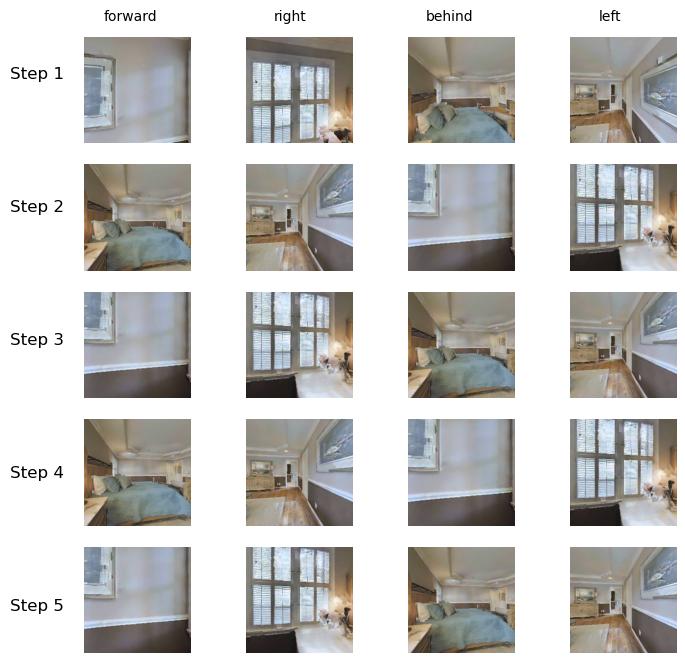

In [40]:
fig, axs = plt.subplots(len(step_observations), 4, figsize=(8,8))
observation_order = ["forward", "right", "behind", "left"]
first_title_x = 0.2

for i, direction in enumerate(observation_order):
        fig.text(first_title_x + (0.2 * i), 0.9, direction, ha='center', fontsize=10)

for step in range(len(step_observations)):
    fig.text(-0.7, 0.6 + (-0.05 * step), f'Step {step+1}', fontsize = 12, transform=axs[step,0].transAxes)
    
    for i in range(4):
        axs[step, i].imshow(step_observations[step][observation_order[i]])
        axs[step, i].axis('off')

#plt.tight_layout()
plt.show()

## Taking an action

Taking action: Turn to face behind you


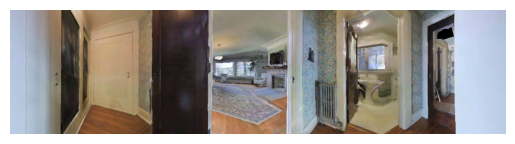

In [117]:
print(f'Taking action: {action[0]}')
take_action(agent, action[0], env_settings)

agent_views, color_observations = get_current_observations(agent)
plt.imshow(cv2.hconcat(color_observations))
plt.axis("off")
plt.show()

In [ ]:
sim.close()

## Test: Video

In [41]:
sim_time = 10
continuous_nav = True

control_frequency = 5
frame_skip = 12

fps = control_frequency * frame_skip # 60 fps
print(f"fps: {fps}")

control_sequence = []
for action in range(int(sim_time * control_frequency)):  #120 actions, spread across 60 fps
    control_sequence.append(
        {
            "rotation_velocity" : -0.3 * 2.0,
            "forward_velocity" : 0.1,
        }
    )

observations = []

velocity_control = habitat_sim.physics.VelocityControl()
velocity_control.controlling_lin_vel = True
velocity_control.lin_vel_is_local = True
velocity_control.controlling_ang_vel = True
velocity_control.ang_vel_is_local = True

# manually controlling the object's kinematic state via velocity integration
time_step = 1.0 / (frame_skip * control_frequency) # 1 / fps

for i, action in enumerate(control_sequence):
    velocity_control.linear_velocity = np.array([0, 0, -action["forward_velocity"]])
    #velocity_control.angular_velocity = np.array([0, action["rotation_velocity"], 0])

    for frame in range(frame_skip):
        #agent_state = agent.state
        previous_rigid_state = habitat_sim.RigidState(utils.quat_to_magnum(agent_state.rotation), agent_state.position)
    
        # manually integrating the rigid state
        target_rigid_state = velocity_control.integrate_transform(time_step, previous_rigid_state)
    
        # snap rigid state to navmesh and set state to object/agent
        end_pos = sim.step_filter(previous_rigid_state.translation, target_rigid_state.translation)

        if False: #frame < 10 and i < 2:
            print(f'agent_state.position {frame}: {agent_state.position}')
            print(f'previous_rigid_state {frame}: {previous_rigid_state.translation}')
            print(f'target_rigid_state {frame}: {target_rigid_state.translation}')
            print(f'end_pos {frame}: {end_pos}')
    
        # setting the computer state
        agent_state.position = end_pos # + np.array([0, height, 0])
        agent_state.rotation = utils.quat_from_magnum(target_rigid_state.rotation)
        agent.set_state(agent_state)
    
        # checking if a collision occured
        dist_moved_before_filter = (target_rigid_state.translation - previous_rigid_state.translation).dot()
        dist_moved_after_filter = (end_pos - previous_rigid_state.translation).dot()
    
        EPS = 1e-5
        collided = (dist_moved_after_filter + EPS) < dist_moved_before_filter
        if collided:
            print(f'collision on frame: {frame}, action: {i}')
    
        sim.step_physics(time_step)
        observations.append(sim.get_sensor_observations())

print(f"frames: {str(len(observations))}")
vut.make_video(
    observations = observations,
    primary_obs = "color_sensor",
    primary_obs_type = "color",
    video_file = os.path.join(output_dir_path, "test_video"),
    fps = fps,
    open_vid = show_video,
)

fps: 60
frames: 600
Encoding the video: /home/wes/Documents/git_ws/OCOM5300M_ResearchProject/outputs/test_video.mp4 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [28]:
agent_state.position

Vector(0.22757, 3.89145, -16.124)

In [77]:
# snapping the agent back to original orientation
agent_state.position = agent_pos + [0,-1,0]
agent_state.rotation = agent_rotation
agent.set_state(agent_state)